# 1. Exploratory Data Analysis

Data Source:

- Constante, Fabian; Silva, Fernando; Pereira, António (2019), “DataCo SMART SUPPLY CHAIN FOR BIG DATA ANALYSIS”, Mendeley Data, V5, doi: 10.17632/8gx2fvg2k6.5

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, normalize
from pycaret.classification import *


## 1.1 Data Description

In [2]:
# load the source data
df_source = pd.read_csv('data/raw/DataCoSupplyChainDataset.csv', encoding='unicode_escape')

# convert the date columns to datetime
df_source['order date (DateOrders)']= pd.to_datetime(df_source['order date (DateOrders)'])

print(df_source.shape)
with pd.option_context('display.max_columns', None):
    display(df_source.head())


(180519, 53)


,Type,Days for shipping (real),Days for shipment (scheduled),Benefit per order,Sales per customer,Delivery Status,Late_delivery_risk,Category Id,Category Name,Customer City,Customer Country,Customer Email,Customer Fname,Customer Id,Customer Lname,Customer Password,Customer Segment,Customer State,Customer Street,Customer Zipcode,Department Id,Department Name,Latitude,Longitude,Market,Order City,Order Country,Order Customer Id,order date (DateOrders),Order Id,Order Item Cardprod Id,Order Item Discount,Order Item Discount Rate,Order Item Id,Order Item Product Price,Order Item Profit Ratio,Order Item Quantity,Sales,Order Item Total,Order Profit Per Order,Order Region,Order State,Order Status,Order Zipcode,Product Card Id,Product Category Id,Product Description,Product Image,Product Name,Product Price,Product Status,shipping date (DateOrders),Shipping Mode
0,DEBIT,3,4,91.250000,314.640015,Advance shipping,0,73,Sporting Goods,Caguas,Puerto Rico,XXXXXXXXX,Cally,20755,Holloway,XXXXXXXXX,Consumer,PR,5365 Noble Nectar Island,725.0,2,Fitness,18.251453,-66.037056,Pacific Asia,Bekasi,Indonesia,20755,2018-01-31 22:56:00,77202,1360,13.110000,0.04,180517,327.75,0.29,1,327.75,314.640015,91.250000,Southeast Asia,Java Occidental,COMPLETE,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.75,0,2/3/2018 22:56,Standard Class
1,TRANSFER,5,4,-249.089996,311.359985,Late delivery,1,73,Sporting Goods,Caguas,Puerto Rico,XXXXXXXXX,Irene,19492,Luna,XXXXXXXXX,Consumer,PR,2679 Rustic Loop,725.0,2,Fitness,18.279451,-66.037064,Pacific Asia,Bikaner,India,19492,2018-01-13 12:27:00,75939,1360,16.389999,0.05,179254,327.75,-0.80,1,327.75,311.359985,-249.089996,South Asia,Rajastán,PENDING,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.75,0,1/18/2018 12:27,Standard Class
2,CASH,4,4,-247.779999,309.720001,Shipping on time,0,73,Sporting Goods,San Jose,EE. UU.,XXXXXXXXX,Gillian,19491,Maldonado,XXXXXXXXX,Consumer,CA,8510 Round Bear Gate,95125.0,2,Fitness,37.292233,-121.881279,Pacific Asia,Bikaner,India,19491,2018-01-13 12:06:00,75938,1360,18.030001,0.06,179253,327.75,-0.80,1,327.75,309.720001,-247.779999,South Asia,Rajastán,CLOSED,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.75,0,1/17/2018 12:06,Standard Class
3,DEBIT,3,4,22.860001,304.809998,Advance shipping,0,73,Sporting Goods,Los Angeles,EE. UU.,XXXXXXXXX,Tana,19490,Tate,XXXXXXXXX,Home Office,CA,3200 Amber Bend,90027.0,2,Fitness,34.125946,-118.291016,Pacific Asia,Townsville,Australia,19490,2018-01-13 11:45:00,75937,1360,22.940001,0.07,179252,327.75,0.08,1,327.75,304.809998,22.860001,Oceania,Queensland,COMPLETE,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.75,0,1/16/2018 11:45,Standard Class
4,PAYMENT,2,4,134.210007,298.250000,Advance shipping,0,73,Sporting Goods,Caguas,Puerto Rico,XXXXXXXXX,Orli,19489,Hendricks,XXXXXXXXX,Corporate,PR,8671 Iron Anchor Corners,725.0,2,Fitness,18.253769,-66.037048,Pacific Asia,Townsville,Australia,19489,2018-01-13 11:24:00,75936,1360,29.500000,0.09,179251,327.75,0.45,1,327.75,298.250000,134.210007,Oceania,Queensland,PENDING_PAYMENT,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.75,0,1/15/2018 11:24,Standard Class


In [3]:
# show the data description
df_description = pd.read_csv('data/raw/DescriptionDataCoSupplyChain.csv')
df_description.DESCRIPTION = df_description.DESCRIPTION.str.replace(':', '')

df_description.style.set_properties(**{'text-align': 'left'})

,FIELDS,DESCRIPTION
0,Type,Type of transaction made
1,Days for shipping (real),Actual shipping days of the purchased product
2,Days for shipment (scheduled),Days of scheduled delivery of the purchased product
3,Benefit per order,Earnings per order placed
4,Sales per customer,Total sales per customer made per customer
5,Delivery Status,"Delivery status of orders Advance shipping , Late delivery , Shipping canceled , Shipping on time"
6,Late_delivery_risk,"Categorical variable that indicates if sending is late (1), it is not late (0)."
7,Category Id,Product category code
8,Category Name,Description of the product category
9,Customer City,City where the customer made the purchase


## 1.2 Correlation

References:
- [Plotting a diagonal correlation matrix](https://seaborn.pydata.org/examples/many_pairwise_correlations.html)

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif


<AxesSubplot:>

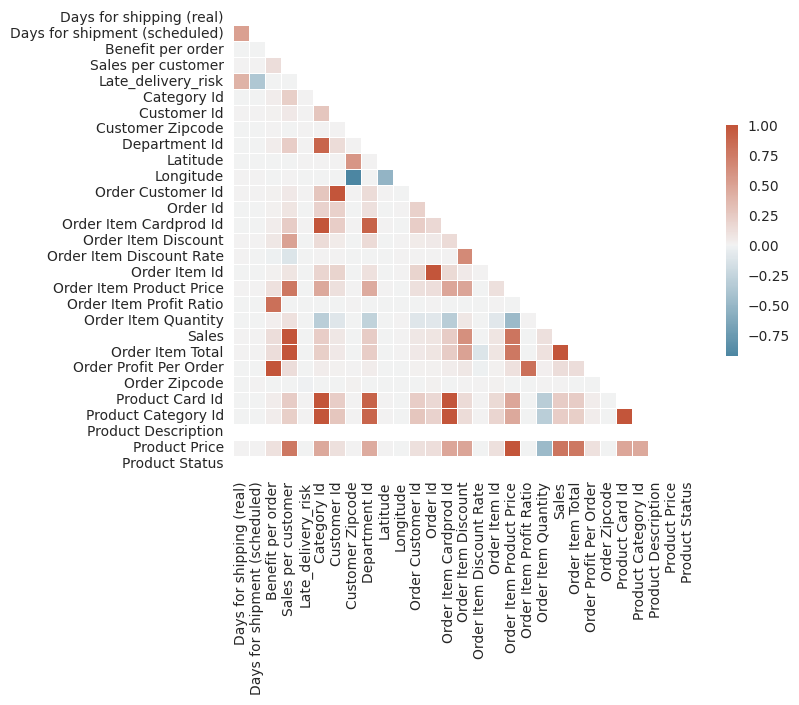

In [4]:
# Compute the correlation matrix
corr = df_source.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(8, 6))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

## 1.3 Fraud

References:
- <div class="csl-entry">Constante-Nicolalde, F.-V., Guerra-Terán, P., &#38; Pérez-Medina, J.-L. (2020). <i>Fraud Prediction in Smart Supply Chains Using Machine Learning Techniques</i> (M. Botto-Tobar, M. Zambrano Vizuete, P. Torres-Carrión, S. Montes León, G. Pizarro Vásquez, &#38; B. Durakovic, Eds.; Vol. 1194, pp. 145–159). Springer International Publishing. https://doi.org/10.1007/978-3-030-42520-3_12</div>

### 1.3.1 Source Columns

#### 1.3.1.1 Order Date

In [5]:
df_source['order date (DateOrders)'].describe()

count                  180519
unique                  65752
top       2016-12-14 12:29:00
freq                        5
first     2015-01-01 00:00:00
last      2018-01-31 23:38:00
Name: order date (DateOrders), dtype: object

#### 1.3.1.2 Payment Type

In [6]:
df_source['Type'].value_counts()

DEBIT       69295
TRANSFER    49883
PAYMENT     41725
CASH        19616
Name: Type, dtype: int64

#### 1.3.1.3 Sales per customer

In [7]:
df_source['Sales per customer'].describe()

count    180519.000000
mean        183.107609
std         120.043670
min           7.490000
25%         104.379997
50%         163.990005
75%         247.399994
max        1939.989990
Name: Sales per customer, dtype: float64

#### 1.3.1.4 Customer State

In [8]:
df_source['Customer State'].value_counts().head(10)

PR    69373
CA    29223
NY    11327
TX     9103
IL     7631
FL     5456
OH     4095
PA     3824
MI     3804
NJ     3191
Name: Customer State, dtype: int64

#### 1.3.1.5 Order State

In [9]:
df_source['Order State'].value_counts().head(10)

Inglaterra                     6722
California                     4966
Isla de Francia                4580
Renania del Norte-Westfalia    3303
San Salvador                   3055
Nueva York                     2753
Distrito Federal               2559
Texas                          2446
Nueva Gales del Sur            2370
Santo Domingo                  2211
Name: Order State, dtype: int64

#### 1.3.1.6 Order Status

In [10]:
df_source['Order Status'].value_counts()

COMPLETE           59491
PENDING_PAYMENT    39832
PROCESSING         21902
PENDING            20227
CLOSED             19616
ON_HOLD             9804
SUSPECTED_FRAUD     4062
CANCELED            3692
PAYMENT_REVIEW      1893
Name: Order Status, dtype: int64

### 1.3.2 Feature Engineering

#### 1.3.2.1 Hour-Month

 this variable is calculated based on the variable “order-date”

In [11]:
def add_hour_month(df_source: pd.DataFrame) -> pd.DataFrame:
    """
    Add a new column to the dataframe that indicates the time of the
    month in which this data was captured.

    Parameters
    ----------
    df_source : pd.DataFrame
        The source dataframe
    """
    df_source['hour-month'] = (df_source['order date (DateOrders)'].dt.day * 24) + df_source['order date (DateOrders)'].dt.hour
    return df_source

add_hour_month(df_source)
df_source['hour-month'].describe()

#(df_source['hour-month'] / df_source['hour-month'].mean()).describe()

count    180519.000000
mean        389.227993
std         211.850418
min          24.000000
25%         206.000000
50%         390.000000
75%         572.000000
max         767.000000
Name: hour-month, dtype: float64

In [12]:
# show the standardized data
scaler = StandardScaler()
scaled = scaler.fit_transform(df_source[['hour-month']].sample(frac=1))
print(f'Mean: {scaled.mean().round()} | Std: {scaled.std().round()} | Median: {np.median(scaled).round(6)} | Min: {scaled.min().round(6)} | Max: {scaled.max().round(6)}')
pd.DataFrame(scaled.round(decimals=3)).describe()

Mean: -0.0 | Std: 1.0 | Median: 0.003644 | Min: -1.723995 | Max: 1.783207


,0
count,180519.000000
mean,-0.000001
std,1.000003
min,-1.724000
25%,-0.865000
50%,0.004000
75%,0.863000
max,1.783000


#### 1.3.2.2 Is Fraud

Calculated binary categorical variable that indicates 0: No Fraud and 1: Fraud

In [13]:
def add_is_fraud(df_source: pd.DataFrame) -> pd.DataFrame:
    """
    Add a new column to the dataframe that indicates
    0: No Fraud and 1: Fraud

    Parameters
    ----------
    df_source : pd.DataFrame
        The source dataframe
    """
    df_source['is_fraud'] = df_source['Order Status'].apply(lambda x: 1 if x == 'SUSPECTED_FRAUD' else 0)
    return df_source

add_is_fraud(df_source)
df_source['is_fraud'].value_counts()

0    176457
1      4062
Name: is_fraud, dtype: int64

### 1.3.3 AutoML Model

Use AutoML to get an idea of the best model for this problem.

#### 1.3.3.1 Data Selection

In [14]:
# find columns with null values
has_nulls = df_source.columns[df_source.isna().any()].tolist()
print(has_nulls)

['Customer Lname', 'Customer Zipcode', 'Order Zipcode', 'Product Description']


In [15]:
remove_columns = [
    *has_nulls,
    'Order Status',     # the target value is derived from this column
    'Order Id',         # data leakage
    'Delivery Status',  # data leakage: suspected fraud orders are often cancelled
    'Customer Fname',
    'shipping date (DateOrders)',
]

print(remove_columns)

['Customer Lname', 'Customer Zipcode', 'Order Zipcode', 'Product Description', 'Order Status', 'Order Id', 'Delivery Status', 'Customer Fname', 'shipping date (DateOrders)']


In [16]:
random_state = 42

df_sample = df_source.sample(frac=1, random_state=random_state) \
    .drop(columns=remove_columns) \
    .drop(columns=[]) \

# create the training dataset
df_unseen = df_sample.sample(frac=0.3, random_state=random_state)
df_train = df_sample.drop(df_unseen.index)

# reset the index of both datasets
df_train.reset_index(drop=True, inplace=True)
df_unseen.reset_index(drop=True, inplace=True)

print(f'Training dataset shape : {df_train.shape}')
print(f'Unseen dataset shape   : {df_unseen.shape}')

Training dataset shape : (126363, 46)
Unseen dataset shape   : (54156, 46)


In [17]:
df_train.is_fraud.value_counts()

0    123477
1      2886
Name: is_fraud, dtype: int64

#### 1.3.3.2 Classifier Setup

In [18]:
# the list of features used in the paper
paper_features = [
    'hour-month',
    'Type',
    'Sales per customer',
    'Customer State',
    'Order State',
    'is_fraud'
]

In [19]:
classifier = setup(
    data=df_train,
    target='is_fraud',
    train_size=0.7,
    session_id=random_state,
    verbose=False)

#### 1.3.3.3 Random Forest

Create A Random Forest Classifier to get idea of feature importance.

In [20]:
rf_classifier = create_model('rf')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9781,0.9508,0.0396,1.0000,0.0762,0.0746,0.1968
1,0.9785,0.9401,0.0594,1.0000,0.1121,0.1099,0.2411
2,0.9777,0.9445,0.0248,1.0000,0.0483,0.0473,0.1556
3,0.9777,0.9559,0.0248,1.0000,0.0483,0.0473,0.1556
4,0.9781,0.9327,0.0446,0.9000,0.0849,0.0829,0.1975
5,0.9791,0.9507,0.0842,1.0000,0.1553,0.1522,0.2870
6,0.9778,0.9446,0.0297,1.0000,0.0577,0.0564,0.1704
7,0.9790,0.9463,0.0792,1.0000,0.1468,0.1439,0.2785
8,0.9781,0.9341,0.0396,1.0000,0.0762,0.0746,0.1968


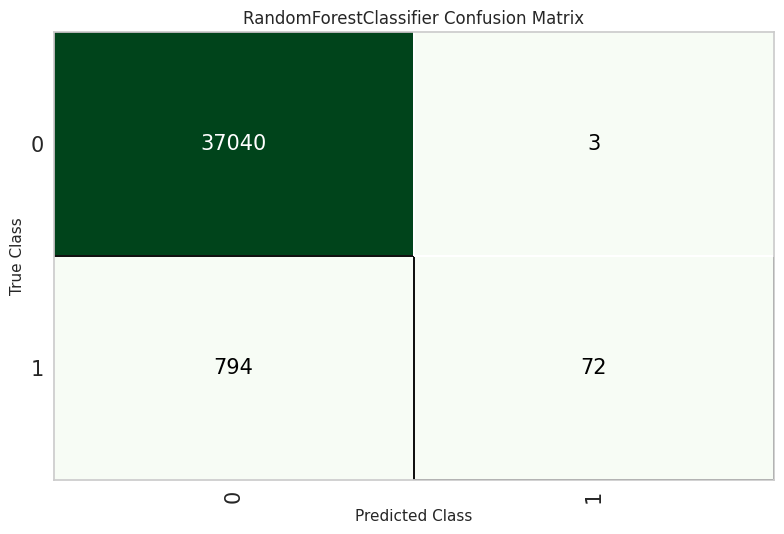

In [21]:
plot_model(rf_classifier, plot='confusion_matrix')

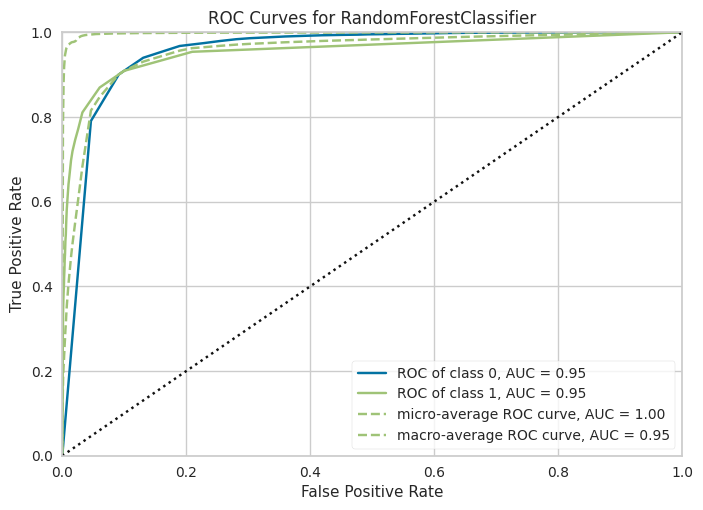

In [22]:
plot_model(rf_classifier, plot='auc')

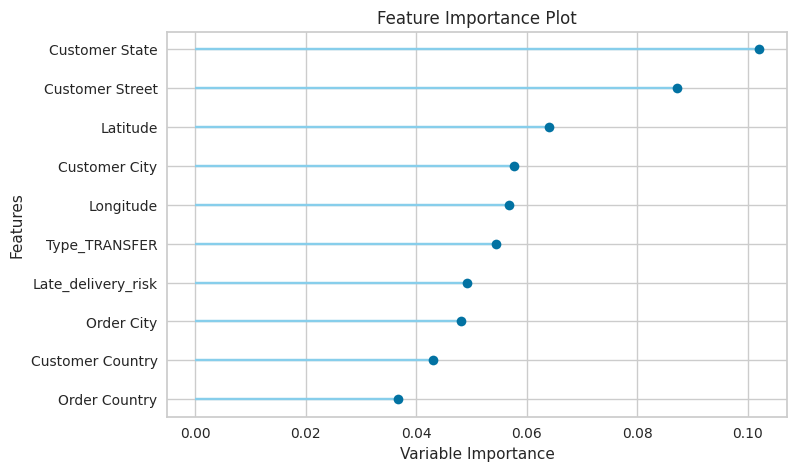

In [23]:
plot_model(rf_classifier, plot='feature')

#### 1.3.3.4 Find Top Models

In [24]:
# perform a model comparison
models = compare_models(n_select=3)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
et,Extra Trees Classifier,0.9836,0.9874,0.2876,0.9817,0.4443,0.4386,0.5263,2.9610
ada,Ada Boost Classifier,0.9800,0.9746,0.1559,0.8368,0.2613,0.2561,0.3541,3.4120
gbc,Gradient Boosting Classifier,0.9787,0.9774,0.0728,0.9579,0.1338,0.1311,0.2541,6.5670
rf,Random Forest Classifier,0.9783,0.9443,0.0485,0.9900,0.0918,0.0899,0.2120,3.1290
dt,Decision Tree Classifier,0.9779,0.5676,0.1376,0.5723,0.2203,0.2133,0.2717,2.2030
ridge,Ridge Classifier,0.9775,0.0000,0.0144,0.9300,0.0281,0.0275,0.1087,1.9000
lr,Logistic Regression,0.9772,0.5171,0.0000,0.0000,0.0000,0.0000,0.0000,2.9260
lightgbm,Light Gradient Boosting Machine,0.9772,0.9657,0.0064,0.4222,0.0126,0.0120,0.0487,2.4440
dummy,Dummy Classifier,0.9772,0.5000,0.0000,0.0000,0.0000,0.0000,0.0000,2.0880
lda,Linear Discriminant Analysis,0.9765,0.9653,0.5901,0.4877,0.5338,0.5219,0.5245,2.5640


### 1.3.4 Visualization

In [25]:
# define plotting function
def myplotGrid(X:np.ndarray, y:np.ndarray, features:list, target:str='class', diag_kind:str='kde') -> None:
    """
    Plot a grid of the interaction between features.

    Parameters
    ----------
    X : ndarray
        The independent (predictory) variables to plot interactions for.
    y : ndarray
        The one dimensional array containing the values of the dependant (target) variable.
    features : list
        The feature names of the independent variables in `X`.
    target : str, optional
        The display name of the target variable.
    diag_kind : {'auto', 'hist', 'kde', None}, optional
        Kind of plot for the diagonal subplots.
    """
    # create a dataframe that can be processed by the seaborne library
    data = pd.DataFrame(X, columns=features)    # create the dataframe from the independent variables
    data[target] = y                            # add the dependant variable to the dataframe

    # use the seaborne library to create a pairplot
    sns.set_theme(style="ticks")
    sns.pairplot(data=data, hue=target, palette='pastel', diag_kind=diag_kind)
    plt.draw()

In [26]:
# a list of columns to remove from the feature list
remove_columns = [

]

selected_features = df_source.columns.to_list()
